# TME4 DQN

In [1]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
from utils_rdl import smooth

import pickle as pkl

import numpy as np
from random import sample, random
from tqdm import tqdm
from collections import deque

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter


# matplotlib.use("TkAgg")
import gym
import gridworld
from gym import wrappers, logger

from utils_rdl import NN
from utils_rdl import play_one_run, train_agent
from utils_rdl import GridWorldMethods, GridWorldFeaturesMethods, CartPoleDiscreteMethods, LunarLanderDiscreteMethods
from utils_rdl import MountainCarContinuousMethods, PendulumContinuousMethods, LunarLanderContinuousMethods
from utils_rdl import BaseAgent, BaseMemAgent


Using matplotlib backend: Qt5Agg


## Agents

In [10]:

class DQNagent(BaseMemAgent):
    def __init__(self, action_space, obs0, layers, lr, Qhat_update_freq, gamma=0.99, eps=.1, eps_decay=.001, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gamma     = gamma
        self.eps       = eps
        self.eps_decay = eps_decay
        self.action_space = action_space
        inSize = self.Phi(obs0).shape[-1]
        outSize = action_space.n
        self.Q    = NN(inSize, outSize, layers, activ='tanh')
        self.Qhat = NN(inSize, outSize, layers, activ='tanh')
        self.Qhat.load_state_dict(self.Q.state_dict(), strict=True)
        self.C = Qhat_update_freq

        ## only the parameters of Q are optimized (not Qhat) :
        self.optimizer = torch.optim.Adam(params=self.Q.parameters(), lr=lr)
        #self.loss_fun = nn.MSELoss()
        self.loss_fun = nn.SmoothL1Loss()

        self.last_a = None
        self.last_s = None
        self.last_phi = None
        self.step = 0
        self.log_dict['loss'] = []

    def update(self, batch):
        s0_s, a0_s, r0_s, s1_s, done0_s = batch
        self.optimizer.zero_grad()
        with torch.no_grad():
            rest = (~done0_s).float() * torch.max(self.Qhat(s1_s), dim=-1, keepdim=True)[0]
            Y = r0_s + self.gamma * rest
        Q_gathered = torch.gather(self.Q(s0_s), 1, a0_s)
        loss = self.loss_fun(Q_gathered, Y)
        loss.backward()
        self.optimizer.step()
        self.log_dict['loss'].append((self.step, loss.item()))
        
        ## update Qhat :
        if self.step%self.C==0:
            self.Qhat.load_state_dict(self.Q.state_dict())
        self.step += 1

#         if self.writer is not None:# and self.step%self.C in (0,1):
#             self.writer.add_scalar('loss', loss, self.step)
#             self.writer.add_histogram('Q output', Q_gathered, self.step)
#         if self.writer and self.step%self.C==0:
#             for i,(fn,fnhat) in enumerate(zip(self.Q.layers, self.Qhat.layers)):
#                 self.writer.add_histogram('param difference/layer{}'.format(i), fn.weight-fnhat.weight, self.step)
#                 self.writer.add_histogram('weights/layer{}'.format(i), fn.weight, self.step)
#                 self.writer.add_histogram('grad/layer{}'.format(i), fn.weight.grad, self.step)

    def act(self, s1):
        with torch.no_grad():
            s1t = torch.from_numpy(s1).view(1,-1)
            x = self.Qhat(s1t)
            a1 = int(torch.argmax(x))
        return a1        
    def act_explore(self, s1):
        ## eps-greedy choice of a1
        self.eps *= self.eps_decay
        p = random()
        if (p < self.eps):
            a1 = self.action_space.sample()
        else :
            a1 = self.act(s1)
        return a1
    

## Experiments


### Cartpole

In [11]:
env_methods = CartPoleDiscreteMethods()
env = gym.make(env_methods.get_env_name())


env_name = 'CartPole-v1'


In [17]:
gamma = .9
eps   = .2
eps_decay = 0.9999

layers = [200]
batch_size = 100
lr = 1e-2

env.seed(0)
params = {'mem_size': 100000, 'Qhat_update_freq':20}

obs0 = env.reset()
agent = DQNagent(env.action_space,
    obs0=obs0,
    batch_size=batch_size,
    layers=layers, lr=lr,
    gamma=gamma,
    eps=eps, eps_decay=eps_decay,
    env_methods=env_methods,
    **params,
    )


out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=500)

play_one_run(agent, env, verbose=2)
    


Episode 1	num_iter=15	DONE    	rsum=15.0
Episode 2	num_iter=18	DONE    	rsum=18.0
Episode 3	num_iter=11	DONE    	rsum=11.0
Episode 4	num_iter=16	DONE    	rsum=16.0
Episode 5	num_iter=15	DONE    	rsum=15.0
Episode 6	num_iter=11	DONE    	rsum=11.0
Episode 7	num_iter=15	DONE    	rsum=15.0
Episode 8	num_iter=14	DONE    	rsum=14.0
Episode 9	num_iter=15	DONE    	rsum=15.0
Episode 10	num_iter=16	DONE    	rsum=16.0
Episode 11	num_iter=12	DONE    	rsum=12.0
Episode 12	num_iter=19	DONE    	rsum=19.0
Episode 13	num_iter=17	DONE    	rsum=17.0
Episode 14	num_iter=15	DONE    	rsum=15.0
Episode 15	num_iter=17	DONE    	rsum=17.0
Episode 16	num_iter=13	DONE    	rsum=13.0
Episode 17	num_iter=21	DONE    	rsum=21.0
Episode 18	num_iter=19	DONE    	rsum=19.0
Episode 19	num_iter=11	DONE    	rsum=11.0
Episode 20	num_iter=20	DONE    	rsum=20.0
Episode 21	num_iter=17	DONE    	rsum=17.0
Episode 22	num_iter=16	DONE    	rsum=16.0
Episode 23	num_iter=13	DONE    	rsum=13.0
Episode 24	num_iter=14	DONE    	rsum=14.0
E

Episode 191	num_iter=454	DONE    	rsum=454.0
Episode 192	num_iter=295	DONE    	rsum=295.0
Episode 193	num_iter=154	DONE    	rsum=154.0
Episode 194	num_iter=355	DONE    	rsum=355.0
Episode 195	num_iter=112	DONE    	rsum=112.0
Episode 196	num_iter=213	DONE    	rsum=213.0
Episode 197	num_iter=100	DONE    	rsum=100.0
Episode 198	num_iter=155	DONE    	rsum=155.0
Episode 199	num_iter=156	DONE    	rsum=156.0
Episode 200	num_iter=23	DONE    	rsum=23.0
Episode 201	num_iter=100	DONE    	rsum=100.0
Episode 202	num_iter=273	DONE    	rsum=273.0
Episode 203	num_iter=130	DONE    	rsum=130.0
Episode 204	num_iter=146	DONE    	rsum=146.0
Episode 205	num_iter=162	DONE    	rsum=162.0
Episode 206	num_iter=108	DONE    	rsum=108.0
Episode 207	num_iter=296	DONE    	rsum=296.0
Episode 208	num_iter=116	DONE    	rsum=116.0
Episode 209	num_iter=140	DONE    	rsum=140.0
Episode 210	num_iter=283	DONE    	rsum=283.0
Episode 211	num_iter=150	DONE    	rsum=150.0
Episode 212	num_iter=211	DONE    	rsum=211.0
Episode 213	

Episode 374	num_iter=150	DONE    	rsum=150.0
Episode 375	num_iter=69	DONE    	rsum=69.0
Episode 376	num_iter=392	DONE    	rsum=392.0
Episode 377	num_iter=104	DONE    	rsum=104.0
Episode 378	num_iter=104	DONE    	rsum=104.0
Episode 379	num_iter=249	DONE    	rsum=249.0
Episode 380	num_iter=142	DONE    	rsum=142.0
Episode 381	num_iter=102	DONE    	rsum=102.0
Episode 382	num_iter=150	DONE    	rsum=150.0
Episode 383	num_iter=169	DONE    	rsum=169.0
Episode 384	num_iter=381	DONE    	rsum=381.0
Episode 385	num_iter=156	DONE    	rsum=156.0
Episode 386	num_iter=154	DONE    	rsum=154.0
Episode 387	num_iter=106	DONE    	rsum=106.0
Episode 388	num_iter=414	DONE    	rsum=414.0
Episode 389	num_iter=173	DONE    	rsum=173.0
Episode 390	num_iter=158	DONE    	rsum=158.0
Episode 391	num_iter=106	DONE    	rsum=106.0
Episode 392	num_iter=102	DONE    	rsum=102.0
Episode 393	num_iter=126	DONE    	rsum=126.0
Episode 394	num_iter=102	DONE    	rsum=102.0
Episode 395	num_iter=108	DONE    	rsum=108.0
Episode 396	

(111.0, 111, True)

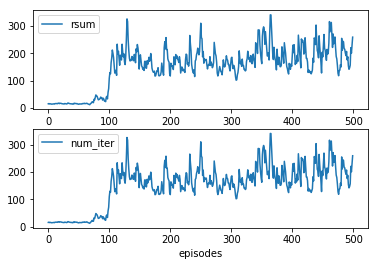

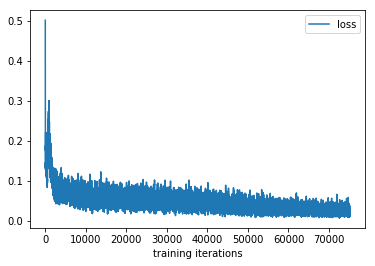

In [18]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(smooth(y, 0.7), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = ['loss']
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()


In [42]:
output_cartpole = out
with open("output_tme4_cartpole.pkl", "wb") as f:
    pkl.dump(output_cartpole, f)
    

>> Ici pendant environs les 100 premiers épisodes, le modèle n'est pas entraîné. Seule la mémoire est remplie.
La valeur maximale (500 iterations) est atteinte ponctuellement mais on constate que l'algorithme se stabilise sur une moyenne de 200pts

### Gridworld

In [33]:
env_methods = GridWorldFeaturesMethods()
env = gym.make(env_methods.get_env_name())


env_name = 'gridworld-v0'
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']


In [34]:
plan_num = 1
plan_rewards = {0:-0.001,3:1,4:1,5:-1,6:-1}
env.setPlan("gridworldPlans/plan{}.txt".format(plan_num), plan_rewards)


['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 4 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n']


In [35]:

# gamma = .9
# eps   = .2
# eps_decay = 0.9999

# layers = [30,30]
# batch_size = 100
# lr = .01

gamma = .7
eps   = .2
eps_decay = 0.9999

layers = [200]
batch_size = 100
lr = 1e-2


params = {'mem_size': 1000000, 'Qhat_update_freq':100}
np.random.seed(5)

obs0 = env.reset()
agent = DQNagent(env.action_space,
    obs0=obs0,
    batch_size=batch_size,
    layers=layers, lr=lr,
    gamma=gamma,
    eps=eps, eps_decay=eps_decay,
    env_methods=env_methods,
    **params,
    )


out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=2500)
# play_one_run(agent, env, verbose=2)



Episode 1	num_iter=486	DONE    	rsum=0.5149999999999997
Episode 2	num_iter=1	DONE    	rsum=-1
Episode 3	num_iter=1	DONE    	rsum=-1
Episode 4	num_iter=2	DONE    	rsum=-1.001
Episode 5	num_iter=1	DONE    	rsum=-1
Episode 6	num_iter=1	DONE    	rsum=-1
Episode 7	num_iter=1	DONE    	rsum=-1
Episode 8	num_iter=1	DONE    	rsum=-1
Episode 9	num_iter=1	DONE    	rsum=-1
Episode 10	num_iter=1	DONE    	rsum=-1
Episode 11	num_iter=1	DONE    	rsum=-1
Episode 12	num_iter=96	DONE    	rsum=0.9049999999999999
Episode 13	num_iter=1	DONE    	rsum=-1
Episode 14	num_iter=410	DONE    	rsum=1.5919999999999996
Episode 15	num_iter=5	DONE    	rsum=-1.004
Episode 16	num_iter=4	DONE    	rsum=-1.003
Episode 17	num_iter=12	DONE    	rsum=-1.011
Episode 18	num_iter=27	DONE    	rsum=-1.026
Episode 19	num_iter=6	DONE    	rsum=-1.005
Episode 20	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 21	num_iter=10	DONE    	rsum=-1.009
Episode 22	num_iter=7	DONE    	rsum=-1.006
Episode 23	num_iter=6	DONE    	rsum=-1.005


Episode 198	num_iter=75	DONE    	rsum=1.927
Episode 199	num_iter=1	DONE    	rsum=-1
Episode 200	num_iter=1	DONE    	rsum=-1
Episode 201	num_iter=1	DONE    	rsum=-1
Episode 202	num_iter=1	DONE    	rsum=-1
Episode 203	num_iter=11	DONE    	rsum=1.991
Episode 204	num_iter=31	DONE    	rsum=1.971
Episode 205	num_iter=1	DONE    	rsum=-1
Episode 206	num_iter=1	DONE    	rsum=-1
Episode 207	num_iter=2	DONE    	rsum=-1.001
Episode 208	num_iter=1	DONE    	rsum=-1
Episode 209	num_iter=1	DONE    	rsum=-1
Episode 210	num_iter=1	DONE    	rsum=-1
Episode 211	num_iter=1	DONE    	rsum=-1
Episode 212	num_iter=3	DONE    	rsum=-1.002
Episode 213	num_iter=1	DONE    	rsum=-1
Episode 214	num_iter=1	DONE    	rsum=-1
Episode 215	num_iter=1	DONE    	rsum=-1
Episode 216	num_iter=1	DONE    	rsum=-1
Episode 217	num_iter=2	DONE    	rsum=-1.001
Episode 218	num_iter=3	DONE    	rsum=-1.002
Episode 219	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 220	num_iter=1	DONE    	rsum=-1
Episode 221	num_iter=1	DONE    	

Episode 389	num_iter=227	DONE    	rsum=1.775
Episode 390	num_iter=12	DONE    	rsum=-1.011
Episode 391	num_iter=4	DONE    	rsum=-1.003
Episode 392	num_iter=12	DONE    	rsum=-1.011
Episode 393	num_iter=5	DONE    	rsum=-1.004
Episode 394	num_iter=18	DONE    	rsum=-1.017
Episode 395	num_iter=32	DONE    	rsum=-1.031
Episode 396	num_iter=5	DONE    	rsum=-1.004
Episode 397	num_iter=1	DONE    	rsum=-1
Episode 398	num_iter=1	DONE    	rsum=-1
Episode 399	num_iter=1	DONE    	rsum=-1
Episode 400	num_iter=1	DONE    	rsum=-1
Episode 401	num_iter=1	DONE    	rsum=-1
Episode 402	num_iter=1	DONE    	rsum=-1
Episode 403	num_iter=1	DONE    	rsum=-1
Episode 404	num_iter=2	DONE    	rsum=-1.001
Episode 405	num_iter=2	DONE    	rsum=-1.001
Episode 406	num_iter=1	DONE    	rsum=-1
Episode 407	num_iter=1	DONE    	rsum=-1
Episode 408	num_iter=1	DONE    	rsum=-1
Episode 409	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 410	num_iter=1	DONE    	rsum=-1
Episode 411	num_iter=4	DONE    	rsum=-0.002000000000000

Episode 590	num_iter=1	DONE    	rsum=-1
Episode 591	num_iter=1	DONE    	rsum=-1
Episode 592	num_iter=1	DONE    	rsum=-1
Episode 593	num_iter=1	DONE    	rsum=-1
Episode 594	num_iter=2	DONE    	rsum=-1.001
Episode 595	num_iter=2	DONE    	rsum=-1.001
Episode 596	num_iter=2	DONE    	rsum=-1.001
Episode 597	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 598	num_iter=1	DONE    	rsum=-1
Episode 599	num_iter=1	DONE    	rsum=-1
Episode 600	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 601	num_iter=1	DONE    	rsum=-1
Episode 602	num_iter=1	DONE    	rsum=-1
Episode 603	num_iter=24	DONE    	rsum=-0.02200000000000002
Episode 604	num_iter=1	DONE    	rsum=-1
Episode 605	num_iter=1	DONE    	rsum=-1
Episode 606	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 607	num_iter=1	DONE    	rsum=-1
Episode 608	num_iter=1	DONE    	rsum=-1
Episode 609	num_iter=2	DONE    	rsum=-1.001
Episode 610	num_iter=1	DONE    	rsum=-1
Episode 611	num_iter=1	DONE    	rsum=-1
Episode 612	num_iter=2	DO

Episode 779	num_iter=60	DONE    	rsum=-0.05800000000000005
Episode 780	num_iter=3	DONE    	rsum=-1.002
Episode 781	num_iter=3	DONE    	rsum=-1.002
Episode 782	num_iter=83	DONE    	rsum=-1.082
Episode 783	num_iter=2	DONE    	rsum=-1.001
Episode 784	num_iter=1	DONE    	rsum=-1
Episode 785	num_iter=1	DONE    	rsum=-1
Episode 786	num_iter=1	DONE    	rsum=-1
Episode 787	num_iter=1	DONE    	rsum=-1
Episode 788	num_iter=2	DONE    	rsum=-1.001
Episode 789	num_iter=1	DONE    	rsum=-1
Episode 790	num_iter=1	DONE    	rsum=-1
Episode 791	num_iter=1	DONE    	rsum=-1
Episode 792	num_iter=2	DONE    	rsum=-1.001
Episode 793	num_iter=1	DONE    	rsum=-1
Episode 794	num_iter=1	DONE    	rsum=-1
Episode 795	num_iter=10	DONE    	rsum=-1.009
Episode 796	num_iter=1	DONE    	rsum=-1
Episode 797	num_iter=3	DONE    	rsum=-1.002
Episode 798	num_iter=1	DONE    	rsum=-1
Episode 799	num_iter=1	DONE    	rsum=-1
Episode 800	num_iter=2	DONE    	rsum=-1.001
Episode 801	num_iter=1	DONE    	rsum=-1
Episode 802	num_iter=1	

Episode 975	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 976	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 977	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 978	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 979	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 980	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 981	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 982	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 983	num_iter=1	DONE    	rsum=-1
Episode 984	num_iter=1	DONE    	rsum=-1
Episode 985	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 986	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 987	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 988	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 989	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 990	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 991	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 992	num_iter=

Episode 1154	num_iter=1	DONE    	rsum=-1
Episode 1155	num_iter=1	DONE    	rsum=-1
Episode 1156	num_iter=1	DONE    	rsum=-1
Episode 1157	num_iter=3	DONE    	rsum=-1.002
Episode 1158	num_iter=1	DONE    	rsum=-1
Episode 1159	num_iter=1	DONE    	rsum=-1
Episode 1160	num_iter=1	DONE    	rsum=-1
Episode 1161	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1162	num_iter=1	DONE    	rsum=-1
Episode 1163	num_iter=1	DONE    	rsum=-1
Episode 1164	num_iter=1	DONE    	rsum=-1
Episode 1165	num_iter=1	DONE    	rsum=-1
Episode 1166	num_iter=2	DONE    	rsum=-1.001
Episode 1167	num_iter=1	DONE    	rsum=-1
Episode 1168	num_iter=1	DONE    	rsum=-1
Episode 1169	num_iter=2	DONE    	rsum=-1.001
Episode 1170	num_iter=171	DONE    	rsum=-0.16900000000000015
Episode 1171	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 1172	num_iter=7	DONE    	rsum=-1.006
Episode 1173	num_iter=1	DONE    	rsum=-1
Episode 1174	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 1175	num_iter=36	DONE    	rsum=-1.03

Episode 1347	num_iter=19	DONE    	rsum=0.982
Episode 1348	num_iter=1	DONE    	rsum=-1
Episode 1349	num_iter=1	DONE    	rsum=-1
Episode 1350	num_iter=1	DONE    	rsum=-1
Episode 1351	num_iter=1	DONE    	rsum=-1
Episode 1352	num_iter=1	DONE    	rsum=-1
Episode 1353	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1354	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 1355	num_iter=10	DONE    	rsum=1.992
Episode 1356	num_iter=1	DONE    	rsum=-1
Episode 1357	num_iter=1	DONE    	rsum=-1
Episode 1358	num_iter=1	DONE    	rsum=-1
Episode 1359	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 1360	num_iter=14	DONE    	rsum=1.988
Episode 1361	num_iter=24	DONE    	rsum=-0.02200000000000002
Episode 1362	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1363	num_iter=47	DONE    	rsum=0.954
Episode 1364	num_iter=303	DONE    	rsum=-0.30100000000000016
Episode 1365	num_iter=9	DONE    	rsum=-1.008
Episode 1366	num_iter=7	DONE    	rsum=-1.006
Episode 1367	num_iter=4	DONE    	rsum

Episode 1555	num_iter=1	DONE    	rsum=-1
Episode 1556	num_iter=4	DONE    	rsum=-1.003
Episode 1557	num_iter=1	DONE    	rsum=-1
Episode 1558	num_iter=1	DONE    	rsum=-1
Episode 1559	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1560	num_iter=1	DONE    	rsum=-1
Episode 1561	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1562	num_iter=1	DONE    	rsum=-1
Episode 1563	num_iter=1	DONE    	rsum=-1
Episode 1564	num_iter=1	DONE    	rsum=-1
Episode 1565	num_iter=1	DONE    	rsum=-1
Episode 1566	num_iter=1	DONE    	rsum=-1
Episode 1567	num_iter=2	DONE    	rsum=-1.001
Episode 1568	num_iter=1	DONE    	rsum=-1
Episode 1569	num_iter=1	DONE    	rsum=-1
Episode 1570	num_iter=1	DONE    	rsum=-1
Episode 1571	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1572	num_iter=1	DONE    	rsum=-1
Episode 1573	num_iter=2	DONE    	rsum=-1.001
Episode 1574	num_iter=1	DONE    	rsum=-1
Episode 1575	num_iter=1	DONE    	rsum=-1
Episode 1576	num_iter=1	DONE    	rsum=-1
Episode 1577	num_iter=2	DO

Episode 1745	num_iter=35	DONE    	rsum=-1.034
Episode 1746	num_iter=2	DONE    	rsum=-1.001
Episode 1747	num_iter=2	DONE    	rsum=-1.001
Episode 1748	num_iter=6	DONE    	rsum=-1.005
Episode 1749	num_iter=18	DONE    	rsum=-1.017
Episode 1750	num_iter=19	DONE    	rsum=-1.018
Episode 1751	num_iter=10	DONE    	rsum=-1.009
Episode 1752	num_iter=11	DONE    	rsum=-1.01
Episode 1753	num_iter=4	DONE    	rsum=-1.003
Episode 1754	num_iter=43	DONE    	rsum=-1.042
Episode 1755	num_iter=8	DONE    	rsum=-1.007
Episode 1756	num_iter=3	DONE    	rsum=-1.002
Episode 1757	num_iter=3	DONE    	rsum=-1.002
Episode 1758	num_iter=9	DONE    	rsum=-1.008
Episode 1759	num_iter=17	DONE    	rsum=-1.016
Episode 1760	num_iter=5	DONE    	rsum=-1.004
Episode 1761	num_iter=11	DONE    	rsum=-1.01
Episode 1762	num_iter=7	DONE    	rsum=-1.006
Episode 1763	num_iter=4	DONE    	rsum=-1.003
Episode 1764	num_iter=1	DONE    	rsum=-1
Episode 1765	num_iter=10	DONE    	rsum=-1.009
Episode 1766	num_iter=27	DONE    	rsum=-1.026
Episod

Episode 1933	num_iter=27	DONE    	rsum=-1.026
Episode 1934	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 1935	num_iter=2	DONE    	rsum=-1.001
Episode 1936	num_iter=1	DONE    	rsum=-1
Episode 1937	num_iter=1	DONE    	rsum=-1
Episode 1938	num_iter=1	DONE    	rsum=-1
Episode 1939	num_iter=1	DONE    	rsum=-1
Episode 1940	num_iter=1	DONE    	rsum=-1
Episode 1941	num_iter=1	DONE    	rsum=-1
Episode 1942	num_iter=1	DONE    	rsum=-1
Episode 1943	num_iter=1	DONE    	rsum=-1
Episode 1944	num_iter=1	DONE    	rsum=-1
Episode 1945	num_iter=1	DONE    	rsum=-1
Episode 1946	num_iter=4	DONE    	rsum=-1.003
Episode 1947	num_iter=20	DONE    	rsum=-1.019
Episode 1948	num_iter=1	DONE    	rsum=-1
Episode 1949	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1950	num_iter=1	DONE    	rsum=-1
Episode 1951	num_iter=1	DONE    	rsum=-1
Episode 1952	num_iter=18	DONE    	rsum=-1.017
Episode 1953	num_iter=1	DONE    	rsum=-1
Episode 1954	num_iter=1	DONE    	rsum=-1
Episode 1955	num_iter=1	DONE    	rs

Episode 2119	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 2120	num_iter=274	DONE    	rsum=-1.2730000000000001
Episode 2121	num_iter=33	DONE    	rsum=-1.032
Episode 2122	num_iter=8	DONE    	rsum=-1.007
Episode 2123	num_iter=21	DONE    	rsum=-1.02
Episode 2124	num_iter=2	DONE    	rsum=-1.001
Episode 2125	num_iter=12	DONE    	rsum=-1.011
Episode 2126	num_iter=2	DONE    	rsum=-1.001
Episode 2127	num_iter=7	DONE    	rsum=-1.006
Episode 2128	num_iter=6	DONE    	rsum=-1.005
Episode 2129	num_iter=6	DONE    	rsum=-1.005
Episode 2130	num_iter=6	DONE    	rsum=-1.005
Episode 2131	num_iter=325	DONE    	rsum=0.6759999999999997
Episode 2132	num_iter=205	DONE    	rsum=0.7959999999999998
Episode 2133	num_iter=84	DONE    	rsum=1.918
Episode 2134	num_iter=19	DONE    	rsum=-1.018
Episode 2135	num_iter=2	DONE    	rsum=-1.001
Episode 2136	num_iter=11	DONE    	rsum=1.991
Episode 2137	num_iter=1	DONE    	rsum=-1
Episode 2138	num_iter=4	DONE    	rsum=-1.003
Episode 2139	num_iter=15	DONE    	rsum=-1.0

Episode 2306	num_iter=1	DONE    	rsum=-1
Episode 2307	num_iter=1	DONE    	rsum=-1
Episode 2308	num_iter=3	DONE    	rsum=-1.002
Episode 2309	num_iter=1	DONE    	rsum=-1
Episode 2310	num_iter=1	DONE    	rsum=-1
Episode 2311	num_iter=1	DONE    	rsum=-1
Episode 2312	num_iter=1	DONE    	rsum=-1
Episode 2313	num_iter=1	DONE    	rsum=-1
Episode 2314	num_iter=2	DONE    	rsum=-1.001
Episode 2315	num_iter=2	DONE    	rsum=-1.001
Episode 2316	num_iter=1	DONE    	rsum=-1
Episode 2317	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2318	num_iter=3	DONE    	rsum=-1.002
Episode 2319	num_iter=21	DONE    	rsum=-1.02
Episode 2320	num_iter=94	DONE    	rsum=1.908
Episode 2321	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 2322	num_iter=14	DONE    	rsum=1.988
Episode 2323	num_iter=10	DONE    	rsum=1.992
Episode 2324	num_iter=31	DONE    	rsum=1.971
Episode 2325	num_iter=27	DONE    	rsum=1.975
Episode 2326	num_iter=4	DONE    	rsum=-1.003
Episode 2327	num_iter=10	DONE    	rsum=-1.009
Episode 2328	

Episode 2488	num_iter=2	DONE    	rsum=-1.001
Episode 2489	num_iter=4	DONE    	rsum=1.998
Episode 2490	num_iter=1	DONE    	rsum=-1
Episode 2491	num_iter=1	DONE    	rsum=-1
Episode 2492	num_iter=2	DONE    	rsum=-1.001
Episode 2493	num_iter=1	DONE    	rsum=-1
Episode 2494	num_iter=1	DONE    	rsum=-1
Episode 2495	num_iter=3	DONE    	rsum=-1.002
Episode 2496	num_iter=1	DONE    	rsum=-1
Episode 2497	num_iter=1	DONE    	rsum=-1
Episode 2498	num_iter=1	DONE    	rsum=-1
Episode 2499	num_iter=1	DONE    	rsum=-1
Episode 2500	num_iter=1	DONE    	rsum=-1


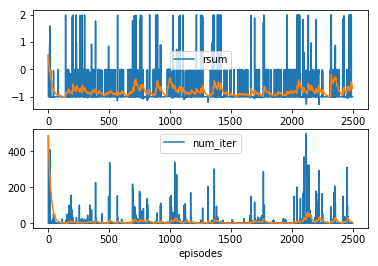

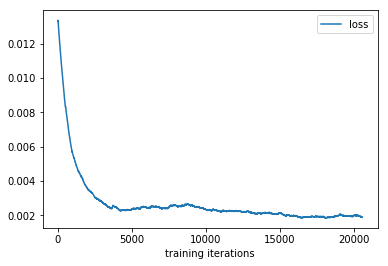

In [40]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.95))
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = ['loss']
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.999), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()



### Lunar Lander

In [28]:
env_methods = LunarLanderDiscreteMethods()
env = gym.make(env_methods.get_env_name())


env_name = 'LunarLander-v2'


In [30]:
# gamma = .99
# eps   = .1
# eps_decay = 0.99999

# layers = [200]
# batch_size = 100
# lr = .0001


# params = {'mem_size': 100, 'Qhat_update_freq':1000}

gamma = .7
eps   = .2
eps_decay = 0.9999

layers = [200]
batch_size = 100
lr = 1e-2

np.random.seed(5)

obs0 = env.reset()
agent = DQNagent(env.action_space,
    obs0=obs0,
    batch_size=batch_size,
    layers=layers, lr=lr,
    gamma=gamma,
    eps=eps, eps_decay=eps_decay,
    env_methods=env_methods,
    **params,
    )


out = train_agent(agent, env, max_iter=1000, verbose=1, num_episodes=300)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=109	DONE    	rsum=-248.4498291047759
Episode 2	num_iter=79	DONE    	rsum=-231.04501821254607
Episode 3	num_iter=55	DONE    	rsum=-137.39698690562085
Episode 4	num_iter=78	DONE    	rsum=-157.8488245598566
Episode 5	num_iter=85	DONE    	rsum=-162.6192641406194
Episode 6	num_iter=67	DONE    	rsum=-149.12408541730105
Episode 7	num_iter=69	DONE    	rsum=-135.8943221655416
Episode 8	num_iter=58	DONE    	rsum=-131.1517904883637
Episode 9	num_iter=90	DONE    	rsum=-169.93850516414386
Episode 10	num_iter=56	DONE    	rsum=-141.10139967555392
Episode 11	num_iter=61	DONE    	rsum=-125.7180234200323
Episode 12	num_iter=59	DONE    	rsum=-112.15975262992399
Episode 13	num_iter=68	DONE    	rsum=-209.678670297805
Episode 14	num_iter=56	DONE    	rsum=-107.25170130457701
Episode 15	num_iter=140	DONE    	rsum=-421.77207197979334
Episode 16	num_iter=128	DONE    	rsum=-295.48757465884336
Episode 17	num_iter=87	DONE    	rsum=-182.63665521844348
Episode 18	num_iter=213	DONE    	rsum=-248.34

Episode 144	num_iter=348	DONE    	rsum=-218.1871079549697
Episode 145	num_iter=709	DONE    	rsum=161.34605246747026
Episode 146	num_iter=334	DONE    	rsum=19.708964764622863
Episode 147	num_iter=360	DONE    	rsum=-33.47459106650554
Episode 148	num_iter=446	DONE    	rsum=268.4374028075896
Episode 149	num_iter=669	DONE    	rsum=249.14852087086848
Episode 150	num_iter=502	DONE    	rsum=245.46661730531764
Episode 151	num_iter=343	DONE    	rsum=-34.72748953547524
Episode 152	num_iter=269	DONE    	rsum=-143.1573594624495
Episode 153	num_iter=287	DONE    	rsum=-34.58393341686157
Episode 154	num_iter=682	DONE    	rsum=-124.53973346534138
Episode 155	num_iter=296	DONE    	rsum=-33.10948771863707
Episode 156	num_iter=473	DONE    	rsum=239.9427698635906
Episode 157	num_iter=680	DONE    	rsum=255.41110585119281
Episode 158	num_iter=408	DONE    	rsum=-80.7342800783013
Episode 159	num_iter=101	DONE    	rsum=-27.750356934932626
Episode 160	num_iter=399	DONE    	rsum=-182.8711849237487
Episode 161	num

Episode 285	num_iter=206	DONE    	rsum=-151.63217066326467
Episode 286	num_iter=344	DONE    	rsum=-195.7937711843382
Episode 287	num_iter=273	DONE    	rsum=-62.60955414785954
Episode 288	num_iter=733	DONE    	rsum=197.304967066517
Episode 289	num_iter=381	DONE    	rsum=-5.447748178744163
Episode 290	num_iter=518	DONE    	rsum=224.23516407392617
Episode 291	num_iter=251	DONE    	rsum=-31.195941372838305
Episode 292	num_iter=382	DONE    	rsum=-195.871586675687
Episode 293	num_iter=235	DONE    	rsum=3.9367992273297006
Episode 294	num_iter=303	DONE    	rsum=-1.0237698683868501
Episode 295	num_iter=771	DONE    	rsum=-325.0673841749109
Episode 296	num_iter=416	DONE    	rsum=206.70783494043846
Episode 297	num_iter=365	DONE    	rsum=-205.00211464707382
Episode 298	num_iter=322	DONE    	rsum=-200.9955731091536
Episode 299	num_iter=856	DONE    	rsum=262.9400420471062
Episode 300	num_iter=316	DONE    	rsum=-138.4892417689457
num_iter=388	DONE    	rsum=246.51783560698553


(246.51783560698553, 388, True)

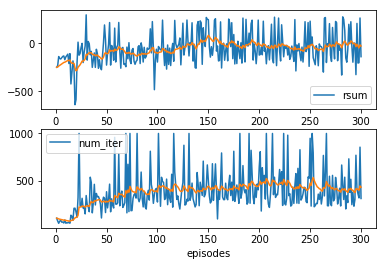

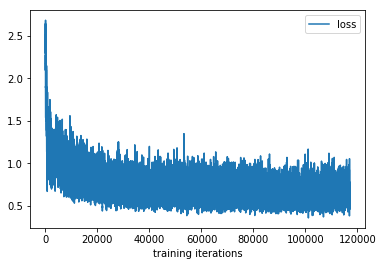

In [32]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = ['loss']
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()

